Library

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM

import data

In [ ]:
df =  pd.read_csv('datasets_614890_1113218_chicago.csv')
df = df[['date_time', 'tempC']]

data preprocessing

In [ ]:
date = df['date_time'].values
temp = df['tempC'].values
temp = temp.astype(np.float32)

In [ ]:
date_train = date[0:3385]
date_valid = date[3385:4232]
temp_train = temp[0:3385]
temp_valid = temp[3385:4232]

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size +1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

model

In [ ]:
train_set = windowed_dataset(temp_train, window_size=60, batch_size=100, shuffle_buffer=1000)
valid_set = windowed_dataset(temp_valid, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.LSTM(60),
                                    tf.keras.layers.Dense(8, activation="relu"),
                                    tf.keras.layers.Dense(1),
])

optimizer and loss function

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=0.1, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

callback

In [ ]:
class callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') is not None and logs.get('mae') <= 6):
      self.model.stop_training = True

callbacks = callback()

training model

In [ ]:
history = model.fit(train_set, epochs=100, callbacks=[callbacks],
                    validation_data=(valid_set), verbose=2)

Epoch 1/100
34/34 - 1s - loss: 8.1842 - mae: 8.6710 - val_loss: 4.5858 - val_mae: 5.0619
Epoch 2/100
34/34 - 1s - loss: 4.2463 - mae: 4.7229 - val_loss: 4.6781 - val_mae: 5.1556


plot mae

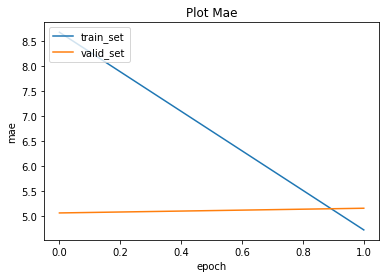

In [184]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Plot Mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train_set', 'valid_set'], loc='upper left')
plt.show()

plot loss

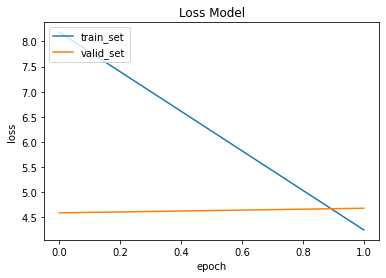

In [185]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_set', 'valid_set'], loc='upper left')
plt.show()